### 🔧 环境配置和检查

#### 概述

本教程需要特定的环境配置以确保最佳学习体验。以下配置将帮助您：

- 使用统一的conda环境：激活统一的学习环境
- 通过国内镜像源快速安装依赖：配置pip使用清华镜像源
- 加速模型下载：设置HuggingFace镜像代理
- 检查系统配置：检查硬件和软件配置

#### 配置

- **所需环境及其依赖已经部署好**
- 在`Notebook`右上角选择`jupyter内核`为`python(flyai_agent_in_action)`，即可执行下方代码

In [ ]:
%%script bash

# 1. 激活 conda 环境 (仅对当前单元格有效)
eval "$(conda shell.bash hook)"
conda activate flyai_agent_in_action

echo "========================================="
echo "== Conda 环境检查报告 (仅针对当前 Bash 子进程) =="
echo "========================================="

# 2. 检查当前激活的环境
CURRENT_ENV_NAME=$(basename $CONDA_PREFIX)

if [ "$CURRENT_ENV_NAME" = "flyai_agent_in_action" ]; then
    echo "✅ 当前单元格已成功激活到 flyai_agent_in_action 环境。"
    echo "✅ 正在使用的环境路径: $CONDA_PREFIX"
    echo ""
    echo "💡 提示: 后续的 Python 单元格将使用 Notebook 当前选择的 Jupyter 内核。"
    echo "   如果需要后续单元格也使用此环境，请执行以下操作:"
    echo "   1. 检查 Notebook 右上角是否已选择 'python(flyai_agent_in_action)'。"
else
    echo "❌ 激活失败或环境名称不匹配。当前环境: $CURRENT_ENV_NAME"
    echo ""
    echo "⚠️ 严重提示: 建议将 Notebook 的 Jupyter **内核 (Kernel)** 切换为 'python(flyai_agent_in_action)'。"
    echo "   (通常位于 Notebook 右上角或 '内核' 菜单中)"
    echo ""
    echo "📚 备用方法 (不推荐): 如果无法切换内核，则必须在**每个**代码单元格的头部重复以下命令:"
    echo ""
    echo "%%script bash"
    echo "# 必须在每个单元格都执行"
    echo "eval \"\$(conda shell.bash hook)\""
    echo "conda activate flyai_agent_in_action"
fi

echo "=========================================" 

In [ ]:
# 2. 设置pip 为清华源
%pip config set global.index-url https://pypi.tuna.tsinghua.edu.cn/simple
%pip config list


In [ ]:
# 3. 设置HuggingFace代理
%env HF_ENDPOINT=https://hf-mirror.com
# 验证：使用shell命令检查
!echo $HF_ENDPOINT

In [ ]:
# 🔍 环境信息检查脚本
#
# 本脚本的作用：
# 1. 安装 pandas 库用于数据表格展示
# 2. 检查系统的各项配置信息
# 3. 生成详细的环境报告表格
#
# 对于初学者来说，这个步骤帮助您：
# - 了解当前运行环境的硬件配置
# - 确认是否满足模型运行的最低要求
# - 学习如何通过代码获取系统信息

# 安装 pandas 库 - 用于创建和展示数据表格
# pandas 是 Python 中最流行的数据处理和分析库
%pip install pandas==2.2.2 tabulate==0.9.0

import platform # 导入 platform 模块以获取系统信息
import os # 导入 os 模块以与操作系统交互
import subprocess # 导入 subprocess 模块以运行外部命令
import pandas as pd # 导入 pandas 模块，通常用于数据处理，这里用于创建表格
import shutil # 导入 shutil 模块以获取磁盘空间信息

# 获取 CPU 信息的函数，包括核心数量
def get_cpu_info():
    cpu_info = "" # 初始化 CPU 信息字符串
    physical_cores = "N/A"
    logical_cores = "N/A"

    if platform.system() == "Windows": # 如果是 Windows 系统
        cpu_info = platform.processor() # 使用 platform.processor() 获取 CPU 信息
        try:
            # 获取 Windows 上的核心数量 (需要 WMI)
            import wmi
            c = wmi.WMI()
            for proc in c.Win32_Processor():
                physical_cores = proc.NumberOfCores
                logical_cores = proc.NumberOfLogicalProcessors
        except:
            pass # 如果 WMI 不可用，忽略错误

    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取 CPU 信息和核心数量
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin' # 更新 PATH 环境变量
        try:
            process_brand = subprocess.Popen(['sysctl', "machdep.cpu.brand_string"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_brand, stderr_brand = process_brand.communicate()
            cpu_info = stdout_brand.decode().split(': ')[1].strip() if stdout_brand else "Could not retrieve CPU info"

            process_physical = subprocess.Popen(['sysctl', "hw.physicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_physical, stderr_physical = process_physical.communicate()
            physical_cores = stdout_physical.decode().split(': ')[1].strip() if stdout_physical else "N/A"

            process_logical = subprocess.Popen(['sysctl', "hw.logicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_logical, stderr_logical = process_logical.communicate()
            logical_cores = stdout_logical.decode().split(': ')[1].strip() if stdout_logical else "N/A"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/cpuinfo 文件获取 CPU 信息和核心数量
            with open('/proc/cpuinfo') as f:
                physical_cores_count = 0
                logical_cores_count = 0
                cpu_info_lines = []
                for line in f:
                    if line.startswith('model name'): # 查找以 'model name'开头的行
                        if not cpu_info: # 只获取第一个 model name
                            cpu_info = line.split(': ')[1].strip()
                    elif line.startswith('cpu cores'): # 查找以 'cpu cores' 开头的行
                        physical_cores_count = int(line.split(': ')[1].strip())
                    elif line.startswith('processor'): # 查找以 'processor' 开头的行
                        logical_cores_count += 1
                physical_cores = str(physical_cores_count) if physical_cores_count > 0 else "N/A"
                logical_cores = str(logical_cores_count) if logical_cores_count > 0 else "N/A"
                if not cpu_info:
                     cpu_info = "Could not retrieve CPU info"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    return f"{cpu_info} ({physical_cores} physical cores, {logical_cores} logical cores)" # 返回 CPU 信息和核心数量


# 获取内存信息的函数
def get_memory_info():
    mem_info = "" # 初始化内存信息字符串
    if platform.system() == "Windows":
        # 在 Windows 上不容易通过标准库获取，需要外部库或 PowerShell
        mem_info = "Requires external tools on Windows" # 设置提示信息
    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取内存大小
        process = subprocess.Popen(['sysctl', "hw.memsize"], stdout=subprocess.PIPE, stderr=subprocess.PIPE) # 运行 sysctl 命令
        stdout, stderr = process.communicate() # 获取标准输出和标准错误
        mem_bytes = int(stdout.decode().split(': ')[1].strip()) # 解析输出，获取内存大小（字节）
        mem_gb = mem_bytes / (1024**3) # 转换为 GB
        mem_info = f"{mem_gb:.2f} GB" # 格式化输出
    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/meminfo 文件获取内存信息
            with open('/proc/meminfo') as f:
                total_mem_kb = 0
                available_mem_kb = 0
                for line in f:
                    if line.startswith('MemTotal'): # 查找以 'MemTotal' 开头的行
                        total_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取总内存（KB）
                    elif line.startswith('MemAvailable'): # 查找以 'MemAvailable' 开头的行
                         available_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取可用内存（KB）

                if total_mem_kb > 0:
                    total_mem_gb = total_mem_kb / (1024**2) # 转换为 GB
                    mem_info = f"{total_mem_gb:.2f} GB" # 格式化输出总内存
                    if available_mem_kb > 0:
                        available_mem_gb = available_mem_kb / (1024**2)
                        mem_info += f" (Available: {available_mem_gb:.2f} GB)" # 添加可用内存信息
                else:
                     mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息

        except:
            mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息
    return mem_info # 返回内存信息

# 获取 GPU 信息的函数，包括显存
def get_gpu_info():
    try:
        # 尝试使用 nvidia-smi 获取 NVIDIA GPU 信息和显存
        result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            gpu_lines = result.stdout.strip().split('\n') # 解析输出，获取 GPU 名称和显存
            gpu_info_list = []
            for line in gpu_lines:
                name, memory = line.split(', ')
                gpu_info_list.append(f"{name} ({memory})") # 格式化 GPU 信息
            return ", ".join(gpu_info_list) if gpu_info_list else "NVIDIA GPU found, but info not listed" # 返回 GPU 信息或提示信息
        else:
             # 尝试使用 lshw 获取其他 GPU 信息 (需要安装 lshw)
            try:
                result_lshw = subprocess.run(['lshw', '-C', 'display'], capture_output=True, text=True)
                if result_lshw.returncode == 0: # 如果命令成功执行
                     # 简单解析输出中的 product 名称和显存
                    gpu_info_lines = []
                    current_gpu = {}
                    for line in result_lshw.stdout.splitlines():
                        if 'product:' in line:
                             if current_gpu:
                                 gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")
                             current_gpu = {'product': line.split('product:')[1].strip()}
                        elif 'size:' in line and 'memory' in line:
                             current_gpu['memory'] = line.split('size:')[1].strip()

                    if current_gpu: # 添加最后一个 GPU 的信息
                        gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")

                    return ", ".join(gpu_info_lines) if gpu_info_lines else "GPU found (via lshw), but info not parsed" # 如果找到 GPU 但信息无法解析，设置提示信息
                else:
                    return "No GPU found (checked nvidia-smi and lshw)" # 如果两个命令都找不到 GPU，设置提示信息
            except FileNotFoundError:
                 return "No GPU found (checked nvidia-smi, lshw not found)" # 如果找不到 lshw 命令，设置提示信息
    except FileNotFoundError:
        return "No GPU found (nvidia-smi not found)" # 如果找不到 nvidia-smi 命令，设置提示信息


# 获取 CUDA 版本的函数
def get_cuda_version():
    try:
        # 尝试使用 nvcc --version 获取 CUDA 版本
        result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            for line in result.stdout.splitlines():
                if 'release' in line: # 查找包含 'release' 的行
                    return line.split('release ')[1].split(',')[0] # 解析行，提取版本号
        return "CUDA not found or version not parsed" # 如果找不到 CUDA 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "CUDA not found" # 如果找不到 nvcc 命令，设置提示信息

# 获取 Python 版本的函数
def get_python_version():
    return platform.python_version() # 获取 Python 版本

# 获取 Conda 版本的函数
def get_conda_version():
    try:
        # 尝试使用 conda --version 获取 Conda 版本
        result = subprocess.run(['conda', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            return result.stdout.strip() # 返回 Conda 版本
        return "Conda not found or version not parsed" # 如果找不到 Conda 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "Conda not found" # 如果找不到 conda 命令，设置提示信息

# 获取物理磁盘空间信息的函数
def get_disk_space():
    try:
        total, used, free = shutil.disk_usage("/") # 获取根目录的磁盘使用情况
        total_gb = total / (1024**3) # 转换为 GB
        used_gb = used / (1024**3) # 转换为 GB
        free_gb = free / (1024**3) # 转换为 GB
        return f"Total: {total_gb:.2f} GB, Used: {used_gb:.2f} GB, Free: {free_gb:.2f} GB" # 格式化输出
    except Exception as e:
        return f"Could not retrieve disk info: {e}" # 如果获取信息出错，设置错误信息

# 获取环境信息
os_name = platform.system() # 获取操作系统名称
os_version = platform.release() # 获取操作系统版本
if os_name == "Linux":
    try:
        # 在 Linux 上尝试获取发行版和版本
        lsb_info = subprocess.run(['lsb_release', '-a'], capture_output=True, text=True)
        if lsb_info.returncode == 0: # 如果命令成功执行
            for line in lsb_info.stdout.splitlines():
                if 'Description:' in line: # 查找包含 'Description:' 的行
                    os_version = line.split('Description:')[1].strip() # 提取描述信息作为版本
                    break # 找到后退出循环
                elif 'Release:' in line: # 查找包含 'Release:' 的行
                     os_version = line.split('Release:')[1].strip() # 提取版本号
                     # 尝试获取 codename
                     try:
                         codename_info = subprocess.run(['lsb_release', '-c'], capture_output=True, text=True)
                         if codename_info.returncode == 0:
                             os_version += f" ({codename_info.stdout.split(':')[1].strip()})" # 将 codename 添加到版本信息中
                     except:
                         pass # 如果获取 codename 失败则忽略

    except FileNotFoundError:
        pass # lsb_release 可能未安装，忽略错误

full_os_info = f"{os_name} {os_version}" # 组合完整的操作系统信息
cpu_info = get_cpu_info() # 调用函数获取 CPU 信息和核心数量
memory_info = get_memory_info() # 调用函数获取内存信息
gpu_info = get_gpu_info() # 调用函数获取 GPU 信息和显存
cuda_version = get_cuda_version() # 调用函数获取 CUDA 版本
python_version = get_python_version() # 调用函数获取 Python 版本
conda_version = get_conda_version() # 调用函数获取 Conda 版本
disk_info = get_disk_space() # 调用函数获取物理磁盘空间信息


# 创建用于存储数据的字典
env_data = {
    "项目": [ # 项目名称列表
        "操作系统",
        "CPU 信息",
        "内存信息",
        "GPU 信息",
        "CUDA 信息",
        "Python 版本",
        "Conda 版本",
        "物理磁盘空间" # 添加物理磁盘空间
    ],
    "信息": [ # 对应的信息列表
        full_os_info,
        cpu_info,
        memory_info,
        gpu_info,
        cuda_version,
        python_version,
        conda_version,
        disk_info # 添加物理磁盘空间信息
    ]
}

# 创建一个 pandas DataFrame
df = pd.DataFrame(env_data)

# 打印表格
print("### 环境信息") # 打印标题
print(df.to_markdown(index=False)) # 将 DataFrame 转换为 Markdown 格式并打印，不包含索引


<a href="https://colab.research.google.com/github/FlyAIBox/langchain-academy/blob/fly101/module-2/state-schema.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 状态模式（State Schema）

## 回顾

在第 1 模块中，我们打好了基础，构建了一个能够：

- `act（行动）`：让模型调用特定工具
- `observe（观察）`：将工具输出回传给模型
- `reason（推理）`：让模型基于工具输出进行推理，决定下一步（例如继续调用工具或直接回复）
- `persist state（持久化状态）`：使用内存检查点器支持可被中断的长对话

我们还演示了如何在本地通过 LangGraph Studio 运行，以及如何使用 LangGraph Cloud 部署。

## 目标

本模块将帮助你更深入地理解“状态（state）”与“记忆（memory）”。

首先，我们来回顾在 LangGraph 中定义状态模式的几种常见方式。

In [ ]:
%%capture --no-stderr
# %pip install --quiet -U langgraph
%pip install langgraph==0.6.7

## 模式说明（Schema）

在定义 LangGraph 的 `StateGraph` 时，我们需要一个[状态模式（state schema）](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)。

状态模式用于描述图中将要使用的数据结构与类型。
所有节点（nodes）都应当遵循并通过该模式进行通信。

---

在 LangGraph 中，**State Schema**（状态模式）是用于定义图的状态（state）或“记忆”（memory）的数据结构。它规定了在整个图的执行过程中，数据是如何在不同节点间共享和传递的。

简单来说，你可以将 State Schema 理解为一个字典（dict），其中每个键（key）代表一个特定的数据字段，而值（value）则存储该字段的实际数据。当图运行时，每个节点都可以访问、读取和更新这个共享的状态字典。

例如，一个简单的状态模式可能包含以下字段：

* `chat_history`: 用于存储用户和 Agent 之间的对话历史。
* `user_input`: 用于存储最新的用户输入。
* `tool_output`: 用于存储工具调用的结果。

通过使用 State Schema，LangGraph 能够实现：

* **跨节点的数据共享**: 不同的节点（如处理用户输入的节点、调用工具的节点、生成响应的节点）都能够访问同一个共享状态，从而实现数据的无缝传递。
* **短时/长时记忆**: 结合数据库（如 Postgres），State Schema 可以支持短时记忆（当前运行的状态）和长时记忆（跨多次运行持久化的状态）。
* **可控的执行流**: 边（edges）可以根据状态中的数据来决定下一步的执行路径，例如，如果 `tool_output` 中包含特定信息，就将控制流路由到另一个节点。

---

LangGraph 在定义状态模式方面非常灵活，既支持多种 Python 的[类型](https://docs.python.org/3/library/stdtypes.html#type-objects)，也支持不同的校验方式。

## TypedDict

正如在模块 1 中提到的，我们可以使用 Python `typing` 模块中的 `TypedDict`。

它允许你声明字典的键及其对应的值类型。

需要注意：这些只是“类型提示（type hints）”。

它们可用于静态类型检查器（例如 [mypy](https://github.com/python/mypy)）或 IDE 在运行前发现潜在的类型问题，

但在运行时并不会强制校验！

In [ ]:
# 说明：使用 TypedDict 定义最基础的“状态模式（State Schema）”
# 提示：TypedDict 只提供类型提示（静态检查），运行时不会强制校验类型
# 适用：入门理解“状态键=通道（channel）”的概念，每个键是一条状态通道
from typing_extensions import TypedDict

class TypedDictState(TypedDict):
    # 必填字符串键：foo（一条状态通道）
    foo: str
    # 必填字符串键：bar（另一条状态通道）
    bar: str

如果需要更严格的取值约束，可以使用 `Literal` 这样的类型提示。

例如，这里将 `mood` 的取值限制为 "happy" 或 "sad"。

In [ ]:
# 说明：通过 Literal 收紧取值范围（仍然是类型提示，运行时不强制）
# 这里将 mood 限定为 "happy" 或 "sad"，便于 IDE/静态检查提前发现潜在问题
from typing import Literal

class TypedDictState(TypedDict):
    # 用户名（字符串）
    name: str
    # 心情（仅允许 "happy" 或 "sad"）
    mood: Literal["happy","sad"]

在 LangGraph 中，我们可以将定义好的状态类（例如这里的 `TypedDictState`）直接传入 `StateGraph` 使用。

可以将每个状态键理解为图中的一条“通道（channel）”。

正如模块 1 所述：在每个节点中，我们会覆盖指定键（即通道）的值。

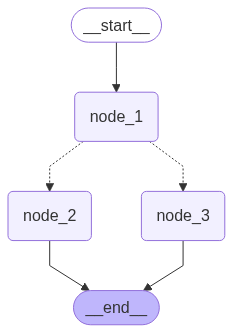

In [ ]:
# 演示：使用 TypedDictState 作为图的“状态模式”
# - 每个节点（node）返回一个子字典来“覆盖”对应的状态键（通道）
# - 这里有 3 个节点：node_1 修改 name；node_2/3 设置 mood
# - 通过条件边（conditional edges）在 node_2 与 node_3 之间二选一
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# 节点函数约定：输入是当前聚合后的 state，返回需要更新的键值对
# 注意：即便 state 是 TypedDict，节点返回值依旧是普通 dict（LangGraph 会按键合并）
def node_1(state):
    print("---Node 1---")
    return {"name": state['name'] + " is ... "}

# 固定将 mood 置为 "happy"
def node_2(state):
    print("---Node 2---")
    return {"mood": "happy"}

# 固定将 mood 置为 "sad"
def node_3(state):
    print("---Node 3---")
    return {"mood": "sad"}

# 路由函数：根据当前 state 决定下一步走向哪个节点
# 返回值必须是已有节点名之一
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    # 这里做一个 50/50 的随机分流，用于演示条件边
    if random.random() < 0.5:
        return "node_2"  # 50% 进入 node_2
    return "node_3"      # 50% 进入 node_3

# 构建图（绑定状态模式）
builder = StateGraph(TypedDictState)
# 注册节点
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 配置边：从 START 到 node_1，然后按条件分流到 node_2 或 node_3，最后到 END
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# 编译得到可执行的图
graph = builder.compile()

# 可视化图结构（Mermaid 渲染）
display(Image(graph.get_graph().draw_mermaid_png()))

由于此处的状态是字典，我们可以直接以字典形式调用图，为状态中的 `name` 键设置初始值。

In [ ]:
# 调用：传入初始状态（dict 形式），只需给出需要初始化的键
# 这里仅初始化 name；mood 将由后续节点写入
graph.invoke({"name":"Lance"})

---Node 1---
---Node 2---


{'name': 'Lance is ... ', 'mood': 'happy'}

## Dataclass（数据类）

Python 的 [dataclasses](https://docs.python.org/3/library/dataclasses.html) 提供了[另一种定义结构化数据的方式](https://www.datacamp.com/tutorial/python-data-classes)。

Dataclass 提供简洁语法，适用于主要用于存放数据的类的定义。

In [ ]:
# 说明：使用 dataclasses 定义状态模式
# 提示：dataclass 一样只提供类型提示，运行时不强制校验
# 区别：访问键的方式从 state["name"] 变为 state.name
from dataclasses import dataclass
from typing import Literal

@dataclass
class DataclassState:
    # 用户名（字符串）
    name: str
    # 心情（仅允许 "happy" 或 "sad" 的类型提示）
    mood: Literal["happy","sad"]

要访问 `dataclass` 的字段，只需调整 `node_1` 中访问的方式：

- `dataclass` 状态使用 `state.name`，而前面的 `TypedDict` 使用 `state["name"]`

你可能会觉得奇怪：在每个节点中，我们依然返回一个普通字典来更新状态。

之所以可以这样做，是因为 LangGraph 会将状态对象的每个键单独存储。

节点返回的对象只需要包含与状态中键（属性）同名的项即可！

在这个例子中，`dataclass` 具有键 `name`，因此我们仍可通过节点返回的 dict 来更新它，这与使用 `TypedDict` 时的做法一致。

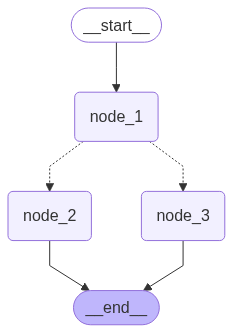

In [ ]:
# 与 TypedDict 版本唯一不同：在节点中以属性访问（state.name）读取值
# 返回值仍是普通 dict（按键合并更新）
def node_1(state):
    print("---Node 1---")
    return {"name": state.name + " is ... "}

# 用 dataclass 版本的状态构建图
builder = StateGraph(DataclassState)
# 其余节点与边的配置复用之前定义的 node_2/node_3/decide_mood
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 边关系相同
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# 编译
graph = builder.compile()

# 可视化
display(Image(graph.get_graph().draw_mermaid_png()))

我们可以直接传入一个 `dataclass` 实例来设置状态中各个键（通道）的初始值！

In [ ]:
# 调用：dataclass 作为初始状态对象，按字段名提供初始值
graph.invoke(DataclassState(name="Lance", mood="sad"))

---Node 1---
---Node 3---


{'name': 'Lance is ... ', 'mood': 'sad'}

## Pydantic

如前所述，`TypedDict` 与 `dataclasses` 仅提供类型提示，并不会在运行时强制类型校验。

这意味着即使赋予了非法值，代码也可能不会报错！

例如，即便类型提示为 `mood: Literal["happy","sad"]`，你仍然可以将 `mood` 设为 `mad`，这在运行时并不会触发异常。

In [ ]:
# 演示：dataclass 不做运行时校验，因此这行不会抛错（但与类型提示冲突）
# 在大型应用中建议使用运行时校验（例如 Pydantic）保证数据质量
dataclass_instance = DataclassState(name="Lance", mood="mad")

[Pydantic](https://docs.pydantic.dev/latest/api/base_model/) 是一个基于 Python 类型注解的数据校验与配置管理库。

得益于其强大的校验能力，它非常适合用于 [在 LangGraph 中定义状态模式](https://langchain-ai.github.io/langgraph/how-tos/state-model/)。

Pydantic 能在运行时校验数据是否符合指定的类型与约束。

In [ ]:
# 说明：使用 Pydantic 定义状态模式（支持运行时校验）
# 优点：当输入数据不满足约束时，立即抛出 ValidationError，避免“脏数据”进入系统
from pydantic import BaseModel, field_validator, ValidationError

class PydanticState(BaseModel):
    name: str
    mood: str  # 运行时将校验值必须在 {"happy", "sad"} 内

    @field_validator('mood')
    @classmethod
    def validate_mood(cls, value):
        # 运行时校验：确保 mood 只能是 "happy" 或 "sad"
        if value not in ["happy", "sad"]:
            raise ValueError("Each mood must be either 'happy' or 'sad'")
        return value

# 演示：传入非法值将触发校验异常
try:
    state = PydanticState(name="John Doe", mood="mad")
except ValidationError as e:
    print("Validation Error:", e)

Validation Error: 1 validation error for PydanticState
mood
  Value error, Each mood must be either 'happy' or 'sad' [type=value_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/value_error


我们可以将 `PydanticState` 无缝用于图中。

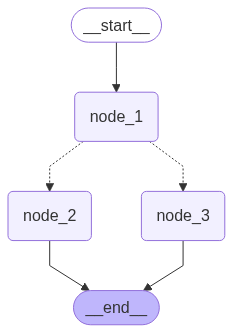

In [ ]:
# 使用 PydanticState 构建图（其余节点逻辑与前面一致）
# 好处：如果某个节点尝试写入非法值，Pydantic 会在运行时报错
builder = StateGraph(PydanticState)

builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# 编译并可视化
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# 调用：将 PydanticState 作为初始状态对象传入（若入参非法会报错）
graph.invoke(PydanticState(name="Lance", mood="sad"))

---Node 1---
---Node 2---


{'name': 'Lance is ... ', 'mood': 'happy'}